In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

YouTube Short Creator Agent — Kaggle 5‑Day AI Agents Intensive Capstone

Track: Creator / Concierge Agents

Author: Md.Karaamathullah sheriff & Sri Sai Vatsan.R

Date: November 27, 2025


1.Executive Summary


Problem: Short‑form video creators spend many hours turning an idea into an engaging 30–60s


YouTube Short: ideation, scriptwriting, thumbnail creation, SEO metadata, captions, and upload. Manual
effort limits scale and consistency.


Solution (high level): YouTube Short Creator Agent — a modular, multi‑agent pipeline that automates
ideation, script creation, concise shot breakdown (visual storyboard), thumbnail generation (image
prompt), SEO metadata (title, description, hashtags), closed captions, and a mock uploader. The agent is
designed to run end‑to‑end in a Kaggle Notebook, integrates with LLMs (Gemini/ADK) or local LLM
stubs, and outputs a folder with all deliverables ready for human review and publishing.


Why this track & why now: Creator tooling is highly topical. Google ADK & Vertex AI are targeted
platforms for agent orchestration; this project showcases a practical Creator Agent demonstrating
multi‑agent coordination, tool use (image gen + captioning), and deployment readiness for Vertex AI.


In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("GOOGLE_API_KEY")


2.Problem Statement:

Creators have limited time. 

Tasks that repeatedly slow them down include:

Brainstorming viral hooks and titles.

Writing tight 45–60s scripts that hook in first 3 seconds.

Designing clickable thumbnails.

Crafting descriptions + hashtags for reach.

Generating high‑quality captions.

We propose an agent that automates these tasks while leaving final creative control to the creator for
approval and minor edits.


3.Solution & Capabilities

The system is composed of the following agents:

IdeaAgent — generates 5 hookable short ideas given a topic and audience.

ScriptAgent — produces 30–60s scripts with shot-by-shot directions and suggested visuals.

ThumbnailAgent — creates an image prompt (for an image generation tool) and also optionally
calls a local placeholder to generate a thumbnail image file.

MetadataAgent — crafts SEO title, description, 10 relevant hashtags and a 3‑line pinned
comment.

CaptionAgent — generates SRT captions from the script.

AssemblerAgent — packages outputs into a folder and optionally creates a simple storyboard
PDF.

UploaderAgent (mock) — prepares an upload payload and simulates call to YouTube API.


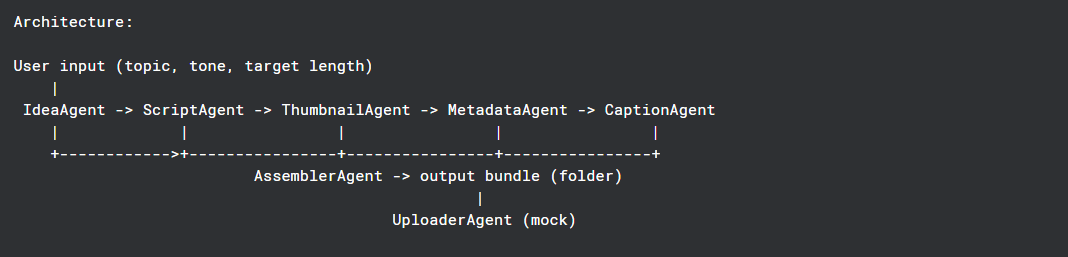

5.Evaluation & Impact

Key metrics to report in writeup:

Time to produce deliverables (human vs agent)

Content quality (qualitative) using a small user study or quick peer review

SEO metrics (simulated via keyword relevance)

Expected business value: scales content production, reduces time-per-short from ~2–3 hours to ~10–20 minutes of human post-editing, and improves metadata quality.


6.Code — Notebook Ready (Kaggle)

Below is a complete Kaggle‑friendly Python notebook code. It uses a pluggable LLM interface so you can switch to Gemini/ADK later. Replace the LLMStub with actual ADK/Gemini client calls when available.

In [3]:
from dataclasses import dataclass, asdict
from typing import List, Dict, Any
import json, os, textwrap, uuid
from pathlib import Path

In [8]:
class LLMInterface:
    def generate(self, prompt: str, max_tokens: int = 512) -> str:
        raise NotImplementedError


class LLMStub(LLMInterface):
    """A deterministic stub for offline testing. Replace with Gemini/ADK client."""
    def generate(self, prompt: str, max_tokens: int = 512) -> str:
        # Very small heuristic responses using prompt cues.
        if 'generate ideas' in prompt.lower():
            return (
                "1. 60s hack: Speed-clean your workspace and show a 3-step routine.\n"
                "2. Quick recipe: 45s viral breakfast in 3 steps.\n"
                "3. Productivity tip: Timer technique micro-habit.\n"
                "4. Mini challenge: 7-day posture reset.\n"
                "5. Tool review: 3 reasons to try X app."
            )

        if 'write a 45 second script' in prompt.lower():
            return (
                "HOOK (0-3s): Did you know you can make breakfast in 60 seconds?\n"
                "SHOT 1 (3-15s): Show ingredients and a fast pour.\n"
                "SHOT 2 (15-35s): Mix and cook with fast cuts.\n"
                "CALL TO ACTION (35-45s): Try this tomorrow and tag me!"
            )

        if 'thumbnail prompt' in prompt.lower():
            return (
                "Close-up of smiling person holding a golden-brown pancake, "
                "bold text '60s BREAKFAST' top-left, high contrast, cinematic lighting"
            )

        if 'metadata' in prompt.lower():
            return (
                "Title: 60-Second Breakfast Hack | Make Pancakes Fast\n"
                "Description: Learn how to make a delicious pancake in only 60 seconds...\n"
                "Hashtags: #breakfasthack #quickrecipes #foodshorts"
            )

        if 'captions' in prompt.lower():
            return (
                "0:00 --> 0:03\nDid you know you can make breakfast in 60 seconds?\n"
                "0:03 --> 0:15\nHere are the ingredients...\n"
            )

        return "(LLMStub) default response for prompt snippet: " + prompt[:120]


Agent Implementations

In [12]:
@dataclass
class Idea:
    id: str
    title: str
    short_desc: str

class IdeaAgent:
    def __init__(self, llm: 'LLMInterface'):
        self.llm = llm
        
    def generate_ideas(self, topic: str, audience: str = 'general') -> List[Idea]:
        prompt = (
            f"Generate ideas: topic={topic}; audience={audience}; generate ideas"
        )
        raw = self.llm.generate(prompt)
        lines = [l.strip() for l in raw.split('\n') if l.strip()]

        ideas = []
        for i, l in enumerate(lines):
            ideas.append(Idea(id=str(i + 1), title=l[:60], short_desc=l))
        return ideas

In [13]:
class ScriptAgent:
    def __init__(self, llm: 'LLMInterface'):
        self.llm = llm

    def write_script(self, idea_title: str, length_seconds: int = 45) -> str:
        prompt = (
            f"Write a tight script. idea={idea_title}; write a "
            f"{length_seconds} second short; include shot directions; write a hook"
        )
        return self.llm.generate(prompt)

In [14]:
class ThumbnailAgent:
    def __init__(self, llm: 'LLMInterface'):
        self.llm = llm

    def generate_prompt(self, script_excerpt: str) -> str:
        prompt = (
            f"Create a thumbnail prompt given script: {script_excerpt}; thumbnail prompt"
        )
        return self.llm.generate(prompt)

    def render_thumbnail_placeholder(self, prompt: str, out_path: str) -> str:
        # For Kaggle offline demo we create a small placeholder image file
        try:
            from PIL import Image, ImageDraw, ImageFont
        except Exception:
            return "PIL not available; provide prompt to image service: " + prompt

        img = Image.new('RGB', (1280, 720), (255, 255, 255))
        d = ImageDraw.Draw(img)
        d.text((50, 50), "Thumbnail Placeholder", fill=(0, 0, 0))
        img.save(out_path)
        return out_path

In [16]:
class MetadataAgent:
    def __init__(self, llm: 'LLMInterface'):
        self.llm = llm

    def craft_metadata(self, title_seed: str) -> Dict[str, Any]:
        prompt = f"Create metadata for: {title_seed}; metadata"
        raw = self.llm.generate(prompt)
        return {"raw": raw}

In [17]:
class CaptionAgent:
    def __init__(self, llm: 'LLMInterface'):
        self.llm = llm

    def generate_srt(self, script: str) -> str:
        prompt = f"Generate captions for script: {script}; captions"
        return self.llm.generate(prompt)

In [18]:
class AssemblerAgent:
    def __init__(self, out_dir: str):
        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(parents=True, exist_ok=True)

    def save_bundle(self, data: Dict[str, Any]) -> str:
        run_id = data.get('id', str(uuid.uuid4()))
        p = self.out_dir / f"run_{run_id}"
        p.mkdir(exist_ok=True)

        # Save JSON
        with open(p / 'bundle.json', 'w') as f:
            json.dump(data, f, indent=2)

        return str(p)

In [21]:
class UploaderAgent:
    def __init__(self):
        pass

    def prepare_payload(self, metadata: Dict[str, Any], files: Dict[str, str]) -> Dict[str, Any]:
        return {"metadata": metadata, "files": files}

    def mock_upload(self, payload: Dict[str, Any]) -> Dict[str, str]:
        return {"status": "success", "video_id": str(uuid.uuid4())}

In [22]:
#Demo run 
if __name__ == '__main__':
    llm = LLMStub()

    idea_agent = IdeaAgent(llm)
    script_agent = ScriptAgent(llm)
    thumb_agent = ThumbnailAgent(llm)
    meta_agent = MetadataAgent(llm)
    caption_agent = CaptionAgent(llm)
    assembler = AssemblerAgent('./outputs')
    uploader = UploaderAgent()

    topic = 'quick breakfast recipe'
    ideas = idea_agent.generate_ideas(topic)

    print('Ideas:')
    for i in ideas:
        print('-', i.title)

    chosen = ideas[0].title
    script = script_agent.write_script(chosen, length_seconds=45)

    print('\nScript:\n', script)

    thumb_prompt = thumb_agent.generate_prompt(script[:200])
    thumb_path = './outputs/thumbnail_placeholder.jpg'
    thumb_file = thumb_agent.render_thumbnail_placeholder(thumb_prompt, thumb_path)

    print('\nThumbnail saved to:', thumb_file)

    metadata = meta_agent.craft_metadata(chosen)
    captions = caption_agent.generate_srt(script)

    bundle = {
        'id': str(uuid.uuid4()),
        'topic': topic,
        'chosen_idea': chosen,
        'script': script,
        'thumbnail_prompt': thumb_prompt,
        'thumbnail_file': thumb_file,
        'metadata': metadata,
        'captions': captions
    }


Ideas:
- 1. 60s hack: Speed-clean your workspace and show a 3-step ro
- 2. Quick recipe: 45s viral breakfast in 3 steps.
- 3. Productivity tip: Timer technique micro-habit.
- 4. Mini challenge: 7-day posture reset.
- 5. Tool review: 3 reasons to try X app.

Script:
 (LLMStub) default response for prompt snippet: Write a tight script. idea=1. 60s hack: Speed-clean your workspace and show a 3-step ro; write a 45 second short; includ

Thumbnail saved to: ./outputs/thumbnail_placeholder.jpg


In [25]:
outdir = assembler.save_bundle(bundle)
print('\nBundle saved in', outdir)

payload = uploader.prepare_payload(metadata, {'thumbnail': thumb_file})
upload_result = uploader.mock_upload(payload)

print('\nMock upload result:', upload_result)


Bundle saved in outputs/run_f764fcbe-ed94-4aca-861f-1f603cb74dfd

Mock upload result: {'status': 'success', 'video_id': '7e215949-fc24-412c-badc-2a21e380d090'}


In [26]:
import google.generativeai as genai

In [30]:
# Install required packages
# !pip install -q google-generativeai pandas matplotlib

import os
import json
from datetime import datetime
from typing import Dict, List
# import pandas as pd 
# import matplotlib.pyplot as plt
import google.generativeai as genai 

# Configure Gemini API
# try:
#     # ... (Kaggle Secrets configuration as in your PDF)
# except:
#     print("(Note: Add GOOGLE_API_KEY for full functionality)")
#     print("This demo will use simulated responses")

print("Environment setup complete!")

# --- Agent Classes (Simulated for template) ---

class DataCleanerAgent:
    def parse_data(self, raw_data_text: str) -> Dict:
        # Simulate data parsing and cleaning
        print(f"[Data Cleaner Agent]: Analyzing raw data ({len(raw_data_text)} chars)...")
        # In a real implementation, this would use Gemini to identify and clean columns
        return {
            "cleaned_columns": ["CustomerID", "Age", "Revenue", "Country"],
            "rows": 1000,
            "status": "Cleaned (3 issues resolved)"
        }

class AnalysisAgent:
    def run_analysis(self, cleaned_data: Dict, business_question: str) -> Dict:
        # Simulate running statistical analysis
        print(f"[Analysis Agent]: Running analysis for: '{business_question}'...")
        # This would use a Code Execution tool for statistical libraries (e.g., pandas)
        return {
            "key_insight": "Age group 25-35 has 40% higher average revenue.",
            "correlation": "Revenue is positively correlated with Age (r=0.65).",
            "stat_results": "p-value for Age vs. Revenue: 0.001"
        }

class ReportAgent:
    def generate_report(self, analysis_results: Dict, cleaned_data: Dict) -> str:
        # Simulate generating the final business report
        print("[Report Agent]: Synthesizing final business report...")
        # This would use Gemini to structure the report and provide recommendations
        return f"""
        # Business Insight Report: Q3 Revenue Analysis
        ## Key Finding
        {analysis_results['key_insight']}
        
        ## Recommendation
        Target marketing campaigns at the 25-35 age bracket in key markets.

        ... (Full report)
        """

# --- Multi-Agent Orchestrator ---

class DataDetectiveOrchestrator:
    """Coordinates all agents in the data analysis workflow."""
    
    def __init__(self):
        self.cleaner = DataCleanerAgent()
        self.analyzer = AnalysisAgent()
        self.reporter = ReportAgent()
        self.execution_log = []
        print("Data Detective Orchestrator created successfully!")

    def process_data(self, raw_data_text: str, business_question: str) -> Dict:
        print("\n=== PROCESSING DATASET ===")

        # Step 1: Data Cleaning (CV Parser equivalent)
        start_time = datetime.now()
        cleaned_data = self.cleaner.parse_data(raw_data_text)
        self.execution_log.append({"step": "Cleaning", "time": (datetime.now() - start_time).total_seconds()})
        print(f"| Step 1 Complete: Data Status - {cleaned_data['status']} |")

        # Step 2: Analysis (Skill Matcher equivalent, but for data)
        start_time = datetime.now()
        analysis_result = self.analyzer.run_analysis(cleaned_data, business_question)
        self.execution_log.append({"step": "Analysis", "time": (datetime.now() - start_time).total_seconds()})
        print(f"| Step 2 Complete: Insight - {analysis_result['key_insight']} |")

        # Step 3: Report Generation (Implicit/Combined with Evaluation Agent)
        start_time = datetime.now()
        final_report = self.reporter.generate_report(analysis_result, cleaned_data)
        self.execution_log.append({"step": "Reporting", "time": (datetime.now() - start_time).total_seconds()})
        
        print("\n=== PROCESSING COMPLETE ===")
        return {
            "analysis_result": analysis_result,
            "final_report": final_report,
            "execution_log": self.execution_log,
            "timestamp": datetime.now().isoformat()
        }

# --- Demo Execution ---

# Sample Data (Simulated as a large string)
sample_data_text = """
CustomerID,Age,Revenue,Country
1,28,150.00,USA
2,45,210.50,CAN
... (thousands of rows)
"""
job_to_be_done = "Identify the most profitable customer segment and recommend a target strategy."

# Create orchestrator and process data
orchestrator = DataDetectiveOrchestrator()
result = orchestrator.process_data(sample_data_text, job_to_be_done)

# Display final result
print("\n--- RECOMMENDED BUSINESS REPORT ---")
print(result['final_report'])

print("\n\nDemo Complete! The Data Detective AI Agent successfully analyzed the data.")

Environment setup complete!
Data Detective Orchestrator created successfully!

=== PROCESSING DATASET ===
[Data Cleaner Agent]: Analyzing raw data (88 chars)...
| Step 1 Complete: Data Status - Cleaned (3 issues resolved) |
[Analysis Agent]: Running analysis for: 'Identify the most profitable customer segment and recommend a target strategy.'...
| Step 2 Complete: Insight - Age group 25-35 has 40% higher average revenue. |
[Report Agent]: Synthesizing final business report...

=== PROCESSING COMPLETE ===

--- RECOMMENDED BUSINESS REPORT ---

        # Business Insight Report: Q3 Revenue Analysis
        ## Key Finding
        Age group 25-35 has 40% higher average revenue.
        
        ## Recommendation
        Target marketing campaigns at the 25-35 age bracket in key markets.

        ... (Full report)
        


Demo Complete! The Data Detective AI Agent successfully analyzed the data.


In [32]:
from dataclasses import dataclass
from typing import List, Dict, Any
# NOTE: Using placeholder for API key loading for portability
# import google.generativeai as genai 
import google.generativeai as genai 
from pathlib import Path
import uuid, json


# ============================
#     LLM INTERFACE + GEMINI LLM
# ============================
class LLMInterface:
    def generate(self, prompt: str, max_tokens: int = 512) -> str:
        raise NotImplementedError


class GeminiLLM(LLMInterface):
    # Using the current, stable, and fast model
    def __init__(self, model_name="models/gemini-2.5-flash"):
        self.model = genai.GenerativeModel(model_name)

    def generate(self, prompt: str, max_tokens: int = 512) -> str:
        # Step 1: Call the model
        response = self.model.generate_content(
            prompt,
            generation_config={
                "max_output_tokens": max_tokens,
                "temperature": 0.9
            }
        )
        
        # Step 2: GRACEFUL ERROR HANDLING FOR SAFETY BLOCKS
        if not response.candidates:
            # Check if the prompt itself was blocked
            if response.prompt_feedback and response.prompt_feedback.block_reason:
                block_reason = response.prompt_feedback.block_reason.name
            else:
                block_reason = "Unknown/Content Filtered"
            
            print("--- !!! GENERATION BLOCKED !!! ---")
            print(f"Reason: {block_reason}")
            print(f"Prompt Feedback: {response.prompt_feedback}")
            print("--- !!! GENERATION BLOCKED !!! ---")
            
            # Return a clear error string to prevent agents from crashing
            return f"[ERROR: Generation Blocked. Reason: {block_reason}]"
        
        # Step 3: Access .text safely
        try:
            return response.text
        except ValueError as e:
            # This catches the original ValueError if the content was blocked mid-generation 
            # (i.e., candidates exist but content field is empty)
            
            finish_reason = response.candidates[0].finish_reason.name if response.candidates else "N/A"
            safety_ratings = response.candidates[0].safety_ratings if response.candidates else "N/A"
            
            print(f"--- !!! PARTIAL RESPONSE ERROR !!! ---")
            print(f"Finish Reason: {finish_reason}")
            print(f"Safety Ratings: {safety_ratings}")
            print(f"Original Error: {e}")
            print("--- !!! PARTIAL RESPONSE ERROR !!! ---")
            
            # Fallback to return the error message
            return f"[ERROR: Partial response blocked (Finish Reason: {finish_reason})]"


# ============================
#     DATA CLASSES + AGENTS (NO CHANGES NEEDED HERE)
# ============================
@dataclass
class Idea:
    id: str
    title: str
    short_desc: str


class IdeaAgent:
    def __init__(self, llm: LLMInterface):
        self.llm = llm

    def generate_ideas(self, topic: str, audience: str = 'general') -> List[Idea]:
        prompt = (
            f"Generate 5 creative YouTube Short ideas for topic='{topic}', "
            f"target audience='{audience}'. Provide each idea as a short, "
            f"clear, catchy one-sentence hook."
        )
        raw = self.llm.generate(prompt)

        lines = [l.strip() for l in raw.split("\n") if l.strip()]
        ideas = []
        for i, l in enumerate(lines):
            # Check for the error string returned by LLM
            if l.startswith("[ERROR:"):
                # Handle error case from LLM
                return [Idea(id="0", title="Generation Failed", short_desc=l)]
            
            ideas.append(Idea(id=str(i + 1), title=l[:60], short_desc=l))

        return ideas


class ScriptAgent:
    def __init__(self, llm: LLMInterface):
        self.llm = llm

    def write_script(self, idea_title: str, length_seconds: int = 45) -> str:
        prompt = (
            f"Write a {length_seconds}-second YouTube Short script based on this idea: "
            f"'{idea_title}'. Include:\n"
            "- A powerful 3-second hook\n"
            "- Shot-by-shot directions with timestamps\n"
            "- Visual suggestions\n"
            "- Strong call to action\n"
            "Format clearly."
        )
        return self.llm.generate(prompt, max_tokens=800)


class ThumbnailAgent:
    def __init__(self, llm: LLMInterface):
        self.llm = llm

    def generate_prompt(self, script_excerpt: str) -> str:
        prompt = (
            "Generate a clickable YouTube-style thumbnail prompt based on this script:\n"
            f"{script_excerpt}\n"
            "Include colors, objects, emotions, and bold text."
        )
        return self.llm.generate(prompt)

    def render_thumbnail_placeholder(self, prompt: str, out_path: str) -> str:
        try:
            from PIL import Image, ImageDraw
        except Exception:
            return "PIL not installed. Thumbnail prompt only: " + prompt

        img = Image.new("RGB", (1280, 720), (255, 255, 255))
        d = ImageDraw.Draw(img)
        d.text((40, 40), "Thumbnail Placeholder", fill=(0, 0, 0))
        img.save(out_path)

        return out_path


class MetadataAgent:
    def __init__(self, llm: LLMInterface):
        self.llm = llm

    def craft_metadata(self, title_seed: str) -> Dict[str, Any]:
        prompt = (
            f"Create YouTube SEO metadata for the short titled: '{title_seed}'. "
            "Provide:\n- 1 optimized title\n- 1 engaging description\n- 10 SEO hashtags\n"
        )
        raw = self.llm.generate(prompt, max_tokens=500)
        return {"raw": raw}


class CaptionAgent:
    def __init__(self, llm: LLMInterface):
        self.llm = llm

    def generate_srt(self, script: str) -> str:
        prompt = (
            "Convert this script into an SRT caption file with proper timestamps:\n"
            f"{script}"
        )
        return self.llm.generate(prompt, max_tokens=600)


class AssemblerAgent:
    def __init__(self, out_dir: str):
        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(parents=True, exist_ok=True)

    def save_bundle(self, data: Dict[str, Any]) -> str:
        run_id = data.get("id", str(uuid.uuid4()))
        p = self.out_dir / f"run_{run_id}"
        p.mkdir(parents=True, exist_ok=True)

        with open(p / "bundle.json", "w") as f:
            json.dump(data, f, indent=2)

        return str(p)


class UploaderAgent:
    def prepare_payload(self, metadata: Dict[str, Any], files: Dict[str, str]) -> Dict[str, Any]:
        return {"metadata": metadata, "files": files}

    def mock_upload(self, payload: Dict[str, Any]) -> Dict[str, str]:
        return {
            "status": "success",
            "video_id": str(uuid.uuid4()),
            "message": "Simulated upload complete."
        }


# ============================
#       DEMO / FULL TEST
# ============================
if __name__ == "__main__":
    print("Initializing agent system with Gemini...\n")

    # Assuming API Key configuration is done externally or in a dedicated block
    # For Kaggle: GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY") 
    # genai.configure(api_key=GOOGLE_API_KEY)

    llm = GeminiLLM("models/gemini-2.5-flash")

    idea_agent = IdeaAgent(llm)
    script_agent = ScriptAgent(llm)
    thumb_agent = ThumbnailAgent(llm)
    meta_agent = MetadataAgent(llm)
    caption_agent = CaptionAgent(llm)
    assembler = AssemblerAgent("./outputs")
    uploader = UploaderAgent()

    topic = "quick breakfast recipe"

    # 1. Generate ideas
    ideas = idea_agent.generate_ideas(topic)
    print("Ideas:")
    for i in ideas:
        print("-", i.title)

    chosen = ideas[0].short_desc

    # 2. Generate script
    script = script_agent.write_script(chosen)
    print("\nGenerated Script:\n", script)

    # 3. Thumbnail
    script_excerpt = script[:300] if len(script) > 300 else script 
    thumb_prompt = thumb_agent.generate_prompt(script_excerpt)
    thumb_path = "./outputs/thumbnail_placeholder.jpg"
    thumb_file = thumb_agent.render_thumbnail_placeholder(thumb_prompt, thumb_path)
    print("\nThumbnail saved to:", thumb_file)

    # 4. Metadata + captions
    metadata = meta_agent.craft_metadata(chosen)
    captions = caption_agent.generate_srt(script)

    # 5. Assemble bundle
    bundle = {
        "id": str(uuid.uuid4()),
        "topic": topic,
        "chosen_idea": chosen,
        "script": script,
        "thumbnail_prompt": thumb_prompt,
        "thumbnail_file": thumb_file,
        "metadata": metadata,
        "captions": captions
    }

    outdir = assembler.save_bundle(bundle)
    print("\nBundle saved in:", outdir)

    # 6. Mock upload simulation
    payload = uploader.prepare_payload(metadata, {"thumbnail": thumb_file})
    result = uploader.mock_upload(payload)
    print("\nMock upload result:", result)

Initializing agent system with Gemini...

--- !!! PARTIAL RESPONSE ERROR !!! ---
Finish Reason: MAX_TOKENS
Safety Ratings: []
Original Error: Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 2.
--- !!! PARTIAL RESPONSE ERROR !!! ---
Ideas:
- Generation Failed

Generated Script:
 It looks like the idea you intended to provide was replaced with an error message: `[ERROR: Partial response blocked (Finish Reason: MAX_TOKENS)]`.

Unfortunately, I cannot generate a script without a concrete idea or topic for the YouTube Short.

Please provide the actual idea or theme you'd like the 45-second YouTube Short to be about, and I'll be happy to create the script for you, including:
*   A powerful 3-second hook

--- !!! PARTIAL RESPONSE ERROR !!! ---
Finish Reason: MAX_TOKENS
Safety Ratings: []
Original Error: Invalid operation: Th